<a href="https://colab.research.google.com/github/redman157/HocML/blob/master/Dog-breed-tulam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"pson2900","key":"977eb592f0fe57a4c97e7d050cf9c637"}'}

In [2]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
# List available datasets.
!kaggle datasets list

-rw-r--r-- 1 root root 64 Apr  5 06:08 kaggle.json
ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          24108  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59          19493  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25          18008  
iarunava/cell-images-for-detecting-malaria                   Malaria Cell Images Dataset                         337MB  2018-12-05 05:40:21           3762  
fivethi

In [3]:
!kaggle competitions download -c dog-breed-identification
!unzip labels.csv.zip
!unzip train.zip
!unzip test.zip

labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  labels.csv.zip
replace labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  train.zip
replace train/000bec180eb18c7604dcecc8fe0dba07.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  test.zip
replace test/000621fb3cbb32d8935728e48679680e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [181]:
import os
import csv
import tempfile
from os import listdir
from io import StringIO
from pathlib import Path
from itertools import islice
from os.path import join, abspath
from collections import namedtuple

import cv2
import pickle
import h5py
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import load_model

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import log_loss
from sklearn.externals import joblib
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold

labels = pd.read_csv('labels.csv')
df_train = os.path.join('train')
df_test = os.path.join('test')
labels.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [0]:
def load_file(fileNames):
  return [join(fileNames,fileName) for fileName in listdir(fileNames)]

In [0]:
train_path = load_file(df_train)
test_path = load_file(df_test)

In [0]:
train_path = sorted(train_path)
test_path = sorted(test_path)

In [95]:
print(len(train_path),len(test_path))

10222 10357


In [0]:
def rescale(img):
  return cv2.resize(img,(100,100),interpolation = cv2.INTER_AREA)
X_train = [rescale(plt.imread(train_path)) for train_path in train_path]
X_test = [rescale(plt.imread(test_path)) for test_path in test_path]


In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [0]:
def save_data(file, fileName):
  with open(fileName, 'wb') as f:
    pickle.dump(file,f)
  f.close()
def open_data(file):
  with open(file,'rb') as f:
    file = pickle.load(f)
  return file
    

In [0]:
save_data(X_train,"trainDf")
save_data(X_test,"testDf")

In [0]:
files_train = open_data("trainDf")
file_test = open_data("testDf")

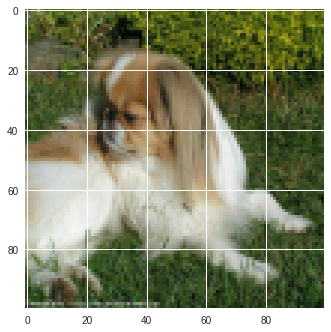

In [178]:
plt.imshow(files_train[0])
plt.imshow(file_test[0])

In [0]:
def process_labels(data):
  breed = data['breed']
  files = []
  for file in breed:
    if file not in files:
      files.append(file)
  _labels = [[index, label] for index, label in enumerate(files)]      

In [0]:
labels = pd.read_csv('labels.csv')
breed = labels['breed']
files = []
for file in breed:
  if file not in files:
    files.append(file)


In [0]:
files.sort()


In [258]:
_labels = [[label, index] for index, label in enumerate(files)]
print(len(breed), len(_labels))

10222 120


In [259]:
_labels[0]

['affenpinscher', 0]

In [0]:
for i in range(len(breed)):
  for j in _labels:
    if breed[i] == j[0]:
      breed[i] = j[1]
      break

In [0]:
def _categorical(data):
  _labels = [label for label in data['breed']]
  count = 0
  _labelsAndCount = []
  for item in _labels:
    _labelsAndCount.append([i,count])
    count = count+1
  return count, _labelsAndCount
# _categorical keras chi so sanh gia tri label voi index 
# vi du son >>> so


In [0]:
from keras.utils import to_categorical
breed = to_categorical(breed)

In [263]:
breed.shape

(10222, 120)

In [264]:
y = np.array(breed)
y.shape

(10222, 120)

In [265]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [0]:
# su dung labelencoder va onehotencode su ly data
labels = pd.read_csv('labels.csv')
breed = labels['breed']

def procesdata_in_sklearn(data):
  enc = LabelEncoder()
  numbers = enc.fit_transform(data)
  df = pd.DataFrame(numbers,data)
  enc1 = OneHotEncoder(categories='auto')
  y = enc1.fit_transform(df).toarray()
  return y

In [0]:
y_pred = procesdata_in_sklearn(breed)


In [322]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])